<a href="https://colab.research.google.com/github/DJCordhose/transformers/blob/main/notebooks/llms-openai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLMS - OpenAI GPT API


* zum Ausführen ist ein OpenAI-Account notwendig: https://platform.openai.com/signup
* hier https://platform.openai.com/api-keys den eigenen Key erzeugen und eintragen
* Kosten
  * https://openai.com/pricing
  * https://platform.openai.com/usage
* Installation und Quickstart: https://platform.openai.com/docs/quickstart?context=python  

In [5]:
import sys
IN_COLAB = 'google.colab' in sys.modules # True if running in Google Colab.
IN_COLAB

True

In [6]:
if IN_COLAB:
    !pip install -q openai tiktoken
    !pip install -q umap-learn

# Tokenizer

* Tokenizer zerlegen Texte in Zahlen
* diese Zahlen korrespondieren mit Token
* Token könnten ganze Worte, Wortteile, Ziffern, Sonderzeichen oder Satzzeiten sein

Links
* https://github.com/openai/tiktoken
* https://platform.openai.com/tokenizer

In [7]:
import tiktoken

# Dies ist der Tokenizer für GPT-4:
enc = tiktoken.encoding_for_model("gpt-4")
assert enc.decode(enc.encode("Hallo, Welt")) == "Hallo, Welt"
enc.encode("Hallo, Welt!0")

[79178, 11, 46066, 0, 15]

# OpenAI Client

In [8]:
# TODO: hier https://platform.openai.com/api-keys den eigenen Key erzeugen und eintragen
OPENAI_API_KEY = '...'

assert OPENAI_API_KEY != '...', "Bitte tragen Sie Ihren OpenAI API Key ein!"

In [9]:
from openai import OpenAI

client = OpenAI(
  api_key=OPENAI_API_KEY
)
models = client.models.list()

In [10]:
set([model.owned_by for model in models])

{'openai', 'openai-internal', 'system'}

In [11]:
set([model.id for model in models if model.owned_by == 'openai'])

{'gpt-3.5-turbo',
 'gpt-3.5-turbo-0301',
 'gpt-3.5-turbo-0613',
 'gpt-3.5-turbo-16k-0613',
 'gpt-4',
 'gpt-4-0613'}

In [12]:
# https://platform.openai.com/docs/api-reference/chat/create
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "Du bist ein Experte im Bereich Machine Learning. Deine Antworten sind kurz und gut."},
    {"role": "user", "content": "Warum sind große Sprachmodelle so mächtig?"},
  ],
  logprobs=True,
  top_logprobs=3
)
completion.choices[0].message.content

'Große Sprachmodelle sind so mächtig, weil sie über riesige Datensätze verfügen und komplexe Muster in natürlicher Sprache erfassen und generieren können. Dies wird durch die Vielzahl an Trainingsdaten und die Fähigkeit des Modells, kontextbezogene Informationen zu nutzen, ermöglicht.'

In [13]:
# for token in completion.choices[0].logprobs.content:
#   print("---")
#   print(token.token)
#   for top_token in token.top_logprobs:
#     print(f"{top_token.token}: {top_token.logprob}")

# Embeddings

Einführung
* https://qdrant.tech/documentation/concepts/search/
* https://openai.com/blog/new-embedding-models-and-api-updates

Links
* https://openai.com/blog/introducing-text-and-code-embeddings
* https://platform.openai.com/docs/guides/embeddings
* https://platform.openai.com/docs/quickstart?context=python&lang=Embeddings
* https://platform.openai.com/docs/guides/embeddings/what-are-embeddings



In [26]:
import numpy as np

texts=[
    "Das Essen war toll und die Bedienung war super!",
    "Uns hat das Restaurant sehr gefallen, sowohl die Speisen als auch der Service!",
    "Was für ein übles Erlebnis, meine Nudeln waren viel zu weich und es hat ewig gedauert, bis wir unser bedient wurden.",
    "Top Restaurant",
    "Elendiger Fraß",
    "Ich hatte nach dem Essen Salmonellen",
    "Hunde mögen gern Knochen.",
    "Katzen lieben Wollknäuel",
]

response = client.embeddings.create(
    # https://openai.com/blog/new-embedding-models-and-api-updates
  # model="text-embedding-ada-002",  # Klassiker
  model="text-embedding-3-small",  # Das Neue in klein
  # model="text-embedding-3-large",  # Das Neue in groß
  input=texts
)

embeddings = np.array([embedding.embedding for embedding in response.data])
embeddings.shape

(8, 3072)

### Ähnlichkeit und Nähe von Embeddings

https://qdrant.tech/documentation/concepts/search/

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_matrix = cosine_similarity(embeddings)
cos_sim_matrix = np.round(cos_sim_matrix, 2)
cos_sim_matrix

array([[1.  , 0.7 , 0.51, 0.35, 0.28, 0.34, 0.3 , 0.21],
       [0.7 , 1.  , 0.47, 0.41, 0.26, 0.29, 0.29, 0.19],
       [0.51, 0.47, 1.  , 0.24, 0.41, 0.42, 0.26, 0.19],
       [0.35, 0.41, 0.24, 1.  , 0.18, 0.18, 0.09, 0.04],
       [0.28, 0.26, 0.41, 0.18, 1.  , 0.37, 0.32, 0.26],
       [0.34, 0.29, 0.42, 0.18, 0.37, 1.  , 0.25, 0.17],
       [0.3 , 0.29, 0.26, 0.09, 0.32, 0.25, 1.  , 0.46],
       [0.21, 0.19, 0.19, 0.04, 0.26, 0.17, 0.46, 1.  ]])

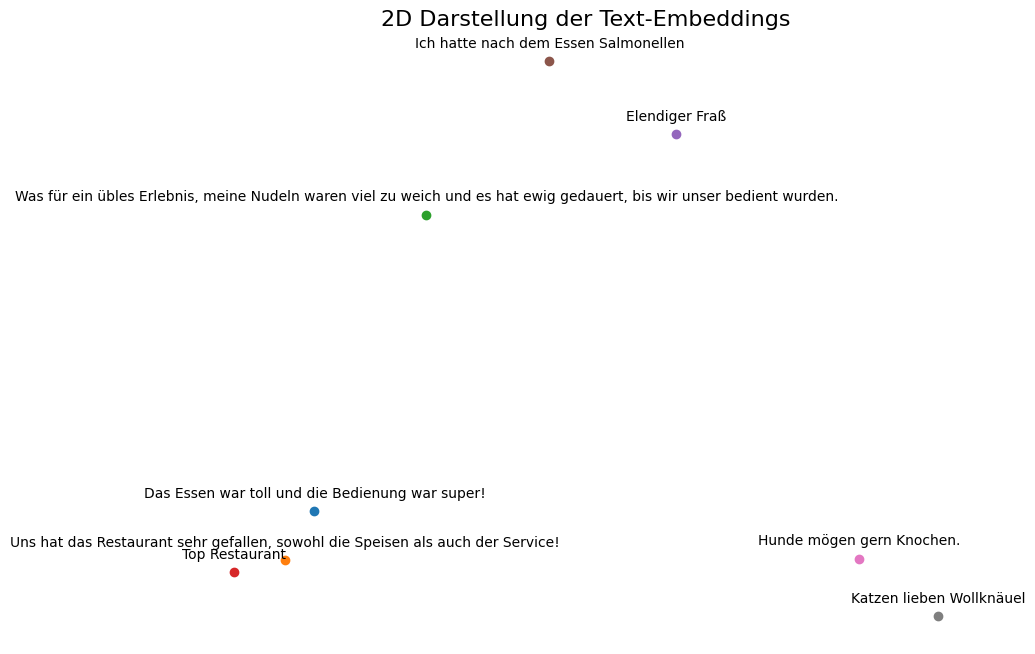

In [28]:
import matplotlib.pyplot as plt

# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=3)
# reduced_embeddings = tsne.fit_transform(embeddings)

# from umap import UMAP
# umap = UMAP(n_components=2, random_state=42, n_neighbors=3)
# reduced_embeddings = umap.fit_transform(embeddings)

# macht als einziges Sinn bei so wenigen Beispielen
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
for i, label in enumerate(texts):
    x, y = reduced_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.xticks([])
plt.yticks([])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# plt.xlabel('1. Hauptkomponente')
# plt.ylabel('2. Hauptkomponente')

# add space between title and plot
plt.subplots_adjust(top=1.5)

plt.title('2D Darstellung der Text-Embeddings', fontsize=16)

# compress distance between points
plt.gca().set_aspect('equal', 'box')


plt.show();

# Prompt Engineering

Das hier ist das Ergebnis von https://platform.openai.com/playground/p/9Fsbs7sYgmiY4mFAHFeR1QX5?mode=chat

In [ ]:
response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {
      "role": "system",
      "content": "Bewerte den eingegebenen Text anhand der ausgedrückten Stimmung mit einem Wert zwischen 0 und 1. 0 für ein negatives Ergebnis, 1 für ein positives. \n\nBeispiele:\nUser: Ich weiß auch nicht so recht.\nAssistent: {'sentiment': 0.5 }\n\nUser: Das ist richtig toll.\nAssistent: {'sentiment': 1.0 }\n\nUser: Ganz schlimm.\nAssistent: {'sentiment': 0.0 }\n\nErzeuge ein JSON, das mit dem key \"sentiment\" und der Bewertung als value."
    },
    {
      "role": "user",
      "content": "Ich bin mit diesem Artikel zufrieden (von wegen)"
    },
    {
      "role": "assistant",
      "content": "{'sentiment': 0.0}"
    },
    {
      "role": "user",
      "content": "Ich bin mit diesem Artikel zufrieden"
    },
    {
      "role": "assistant",
      "content": "{'sentiment': 1.0}"
    },
    {
      "role": "user",
      "content": "Ich bin mit diesem Artikel zufrieden (zumindest anfänglich)"
    },
    {
      "role": "assistant",
      "content": "{'sentiment': 0.5}"
    },
    {
      "role": "user",
      "content": "Was ist das denn für ein Quatsch?"
    }
  ],
  temperature=1,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)
response.choices[0].message.content

"{'sentiment': 0.0}"

# Function Calling

* https://platform.openai.com/docs/guides/function-calling
* https://cookbook.openai.com/examples/how_to_call_functions_with_chat_models

In [ ]:
anfrage = "Was ist das durschschnittliche Gehalt aller Mitarbeiter?"

In [ ]:
model="gpt-3.5-turbo"

tools = [
    {
        "type": "function",
        "function": {
            "name": "list_employee_ids",
            "description": "Enumerate the integer id of all employees",
            "parameters": {
                "type": "object",
                "properties": {
                }
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "get_employee_detail",
            # "description": "Gets the employee's details including salary and job title based on their id",
            "description": "Gets the employee's details",
            "parameters": {
                "type": "object",
                "properties": {
                    "id": {
                        "type": "integer",
                        "description": "The id of the employee like returned by list_employee_ids",
                    }
                },
                "required": ["id"],
            },
        },
    }

]

def user_input(messages, content = None):
  if content:
    message = {"role": "user", "content": content}
    messages.append(message)
  response = client.chat.completions.create(
      model=model,
      messages=messages,
      tools=tools,
  )
  response_message = response.choices[0].message
  messages.append(response_message)
  return response_message

In [ ]:
employees = [
    {
        "name": "Oliver Zeigermann",
        "position": "CTO",
        "salary": 200_000
    },
    {
        "name": "Chi Nhan Nguyen",
        "position": "CEO",
        "salary": 250_000
    }
]

def get_employee_detail(id):
  print(id)
  if int(id) <= len(employees):
    return employees[id -1]
  return None

def list_employee_ids():
  return list(iter(range(1, len(employees) + 1)))

In [ ]:
import json

def execute_tool_call(tool_call):
    function_name = tool_call.function.name
    function_to_call = globals()[function_name]
    function_args = json.loads(tool_call.function.arguments)

    function_response = function_to_call(**function_args)
    print(f"Calling {function_name} with {function_args}, getting {function_response}")
    return {
            "tool_call_id": tool_call.id,
            "role": "tool",
            "name": function_name,
            "content": json.dumps(function_response),
    }

def execute_tool_calls(messages, tool_calls):
  for tool_call in tool_calls:
    message = execute_tool_call(tool_call)
    messages.append(message)

In [ ]:
messages = []
response_message = user_input(messages, anfrage)
messages

[{'role': 'user',
  'content': 'Was ist das durschschnittliche Gehalt aller Mitarbeiter?'},
 ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_QVqSKVG7ywitNqONNbFHmUCJ', function=Function(arguments='{}', name='list_employee_ids'), type='function')])]

In [ ]:
tool_calls = response_message.tool_calls
assert tool_calls

In [ ]:
execute_tool_calls(messages, tool_calls)
messages

Calling list_employee_ids with {}, getting [1, 2]


[{'role': 'user',
  'content': 'Was ist das durschschnittliche Gehalt aller Mitarbeiter?'},
 ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_QVqSKVG7ywitNqONNbFHmUCJ', function=Function(arguments='{}', name='list_employee_ids'), type='function')]),
 {'tool_call_id': 'call_QVqSKVG7ywitNqONNbFHmUCJ',
  'role': 'tool',
  'name': 'list_employee_ids',
  'content': '[1, 2]'}]

In [ ]:
response_message = user_input(messages)
response_message

ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_gh13OioIlNK3w81zyz8sP209', function=Function(arguments='{"id": 1}', name='get_employee_detail'), type='function'), ChatCompletionMessageToolCall(id='call_sViXDX7iTO8dYaHsUfYphTGb', function=Function(arguments='{"id": 2}', name='get_employee_detail'), type='function')])

In [ ]:
tool_calls = response_message.tool_calls
assert tool_calls
tool_calls

[ChatCompletionMessageToolCall(id='call_gh13OioIlNK3w81zyz8sP209', function=Function(arguments='{"id": 1}', name='get_employee_detail'), type='function'),
 ChatCompletionMessageToolCall(id='call_sViXDX7iTO8dYaHsUfYphTGb', function=Function(arguments='{"id": 2}', name='get_employee_detail'), type='function')]

In [ ]:
execute_tool_calls(messages, tool_calls)
messages

1
Calling get_employee_detail with {'id': 1}, getting {'name': 'Oliver Zeigermann', 'position': 'CTO', 'salary': 200000}
2
Calling get_employee_detail with {'id': 2}, getting {'name': 'Chi Nhan Nguyen', 'position': 'CEO', 'salary': 250000}


[{'role': 'user',
  'content': 'Was ist das durschschnittliche Gehalt aller Mitarbeiter?'},
 ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_QVqSKVG7ywitNqONNbFHmUCJ', function=Function(arguments='{}', name='list_employee_ids'), type='function')]),
 {'tool_call_id': 'call_QVqSKVG7ywitNqONNbFHmUCJ',
  'role': 'tool',
  'name': 'list_employee_ids',
  'content': '[1, 2]'},
 ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_gh13OioIlNK3w81zyz8sP209', function=Function(arguments='{"id": 1}', name='get_employee_detail'), type='function'), ChatCompletionMessageToolCall(id='call_sViXDX7iTO8dYaHsUfYphTGb', function=Function(arguments='{"id": 2}', name='get_employee_detail'), type='function')]),
 {'tool_call_id': 'call_gh13OioIlNK3w81zyz8sP209',
  'role': 'tool',
  'name': 'get_employee_detail',
  'content': '{"name": "Oliver Zeigermann", "positi

In [ ]:
response_message = user_input(messages)
antwort = response_message.content
antwort

'Das durchschnittliche Gehalt aller Mitarbeiter beträgt \\(225,000\\)€.'